In [1]:
import talib
import sys
sys.path.append('../code/poloniex')
import polo_eda as pe

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout, Candlestick
init_notebook_mode(connected=True)

In [2]:
df = pe.read_trade_hist()

In [68]:
df.head()

,amount,globalTradeID,rate,total,tradeID,type
date,,,,,,
2017-06-28 06:08:09,8.215384,179575864,0.015531,0.127597,8102473,buy
2017-06-28 06:08:09,14.992102,179575863,0.015530,0.232827,8102472,buy
2017-06-28 06:08:09,21.675132,179575862,0.015527,0.336543,8102471,buy
2017-06-28 06:08:09,19.499969,179575861,0.015521,0.302658,8102470,buy
2017-06-28 06:08:08,0.026881,179575857,0.015521,0.000417,8102469,buy


In [130]:
def create_tas(df):
    # create ohlc bars
    ticks = df.loc[:, ['rate', 'amount']].iloc[::-1]
    bars = ticks['rate'].resample('1min').ohlc()
    bars = bars.fillna(method='ffill')
    
    # bollinger bands
    # strange bug, if values are small, need to multiply to larger value for some reason
    mult = 1
    last_close = bars.iloc[0]['close']
    lc_m = last_close * mult
    while lc_m < 1:
        mult *= 10
        lc_m = last_close * mult
    
    print('using multiplier of', mult)
    
    upper, middle, lower = talib.BBANDS(bars['close'].values*mult,
                                    timeperiod=10,
                                    nbdevup=2,
                                    nbdevdn=2)
    upper /= mult
    middle /= mult
    lower /= mult
    bars['bband_u'] = upper
    bars['bband_m'] = middle
    bars['bband_l'] = lower
    bars['bband_u'].fillna(method='bfill', inplace=True)
    bars['bband_m'].fillna(method='bfill', inplace=True)
    bars['bband_l'].fillna(method='bfill', inplace=True)
    
    # note: too small of a timeperiod will result in junk data...I think.  or at least very discretized
    mom = talib.MOM(bars['close'].values*mult, timeperiod=14)
    
    bars['mom'] = mom/mult
    bars['mom'].fillna(method='bfill', inplace=True)
    
    return bars

In [131]:
def reject_outliers(sr, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

def remove_outliers(df):
    """
    removes outliers for EDA
    """
    data = {}
    for c in df.columns:
        print(c)
        data[c] = reject_outliers(df[c])
    
    return data

In [132]:
df2 = create_tas(df)

using multiplier of 100


In [133]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1810183 entries, 2014-01-18 04:26:00 to 2017-06-28 06:08:00
Freq: T
Data columns (total 8 columns):
open       float64
high       float64
low        float64
close      float64
bband_u    float64
bband_m    float64
bband_l    float64
mom        float64
dtypes: float64(8)
memory usage: 124.3 MB


In [134]:
df2.head()

,open,high,low,close,bband_u,bband_m,bband_l,mom
date,,,,,,,,
2014-01-18 04:26:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:27:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:28:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:29:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:30:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0


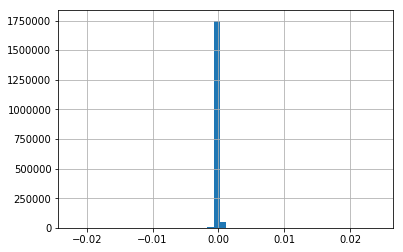

In [135]:
df2['mom'].hist(bins=50)

In [136]:
data = remove_outliers(df2)

open
high
low
close
bband_u
bband_m
bband_l
mom


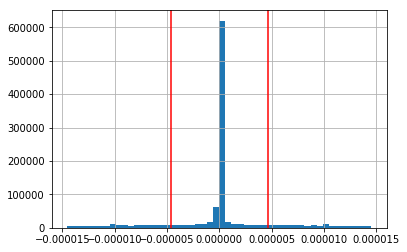

In [145]:
f = data['mom'].hist(bins=50)
l = plt.axvline(data['mom'].std(), c='r')
l = plt.axvline(-data['mom'].std(), c='r')

# for now, notify if above or below 1 std of MOM

In [139]:
data['mom'].std()

4.6504301513332678e-06

In [3]:
upper, middle, lower = talib.BBANDS(df['rate'].values, matype=talib.MA_Type.T3)

In [4]:
df.head()

,amount,globalTradeID,rate,total,tradeID,type
date,,,,,,
2017-06-28 06:08:09,8.215384,179575864,0.015531,0.127597,8102473,buy
2017-06-28 06:08:09,14.992102,179575863,0.015530,0.232827,8102472,buy
2017-06-28 06:08:09,21.675132,179575862,0.015527,0.336543,8102471,buy
2017-06-28 06:08:09,19.499969,179575861,0.015521,0.302658,8102470,buy
2017-06-28 06:08:08,0.026881,179575857,0.015521,0.000417,8102469,buy


In [3]:
small_df = df.iloc[:10000]
# dates = small_df.index

# data = [Scatter(
#             x=dates,
#             y=small_df['rate'].values),
#        Scatter(x=dates, y=upper[:10000]),
#        Scatter(x=dates, y=middle[:10000]),
#        Scatter(x=dates, y=lower[:10000])]
# fig = Figure(data=data)
# iplot(fig)

In [4]:
ticks = small_df.loc[:, ['rate', 'amount']]
bars = ticks['rate'].resample('1min').ohlc()
bars = bars.fillna(method='ffill')

In [57]:
trace = Candlestick(bars, x=bars.index)
dates = bars.index
# http://pythontrader.blogspot.com/2015/05/ta-lib-usage-bollinger-bands.html
upper, middle, lower = talib.BBANDS(bars['close'].values*100, # goddam weird bug, can't deal with small values, but only with pandas data...wtf
                                    timeperiod=10,
                                    nbdevup=2,
                                    nbdevdn=2)#,
                                    #matype=0)  # SMA

scatters = [Scatter(x=dates, y=upper/100, name='upper'),
           Scatter(x=dates, y=middle/100, name='middle'),
           Scatter(x=dates, y=lower/100, name='lower')]

data = [trace] + scatters
iplot(data, filename='simple_candlestick')

In [60]:
mom = talib.MOM(bars['close'].values, timeperiod=5)

In [61]:
dates = bars.index
trace = Candlestick(bars, x=dates)

scatters = [Scatter(x=dates, y=mom, name='MOM')]

data = [trace] + scatters
iplot(data)

ValueError: max must be larger than min in range parameter.

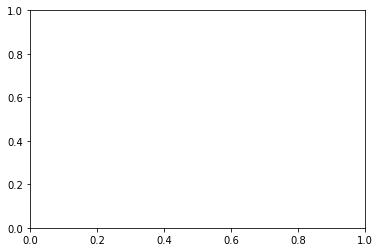

In [62]:
plt.hist(mom)